# Regularyzacja w modelu regresji - porównanie regresji grzbietowej i regresji Lasso

In [50]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

**Regularyzacja grzbietowa** i **Lasso** są technikami, które są wykorzystywane do budowania **oszczędnych modeli**, w rozumieniu obecności zbyt dużej liczby predyktorów. 
Przez dużą liczbę predyktorów rozumiemy:

- *duża liczba predyktorów* to taka, która prowadzi do **przeuczenia modelu** (ang. *overfitting*) -- nawet tak niewielka liczba jak 10 zmiennych może prowadzić do przeuczenia,
    
- *duża liczba predyktorów* to taka, która może prowadzić do problemów z **wydajnością obliczeniową** -- przy obecnych możliwościach komputerów, taka sytuacja może mieć miejsce przy występowaniu milionów lub miliardów cech.

Techniki regularyzacyjne działają poprzez 
- karanie wielkości współczynników cech, 
- minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami.

## [Dlaczego karamy za wielkość współczynników?](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)

Rozważmy następujący przykład celem zrozumienia wpływu złożoności modelu na wielkość współczynników.

W tym celu dopasujmy krzywą regresji do krzywej sinusoidalnej (od 0° do 360°) z dodanym szumem.

In [10]:
np.random.seed(123) 

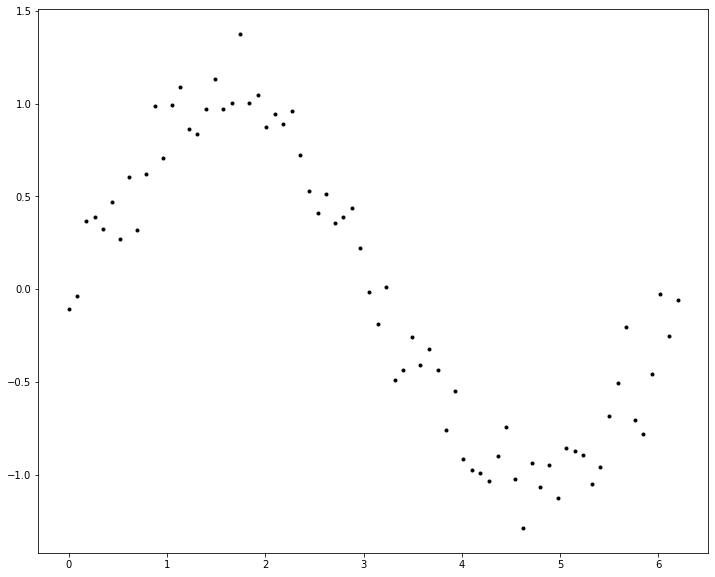

In [212]:
x = np.array([i * np.pi/180 for i in range(0, 360, 5)])
X = pd.DataFrame(x)
y = np.sin(x) + np.random.normal(0, .2, len(x))
plt.plot(x, y, '.', color = 'black')

In [19]:
for i in range(2, 16): 
    colname = 'x_%d'%i      
    data[colname] = data['x'] ** i
data.head()

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,0.000000,-0.080283,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.087266,0.221854,0.007615,0.000665,0.000058,0.000005,4.416561e-07,3.854177e-08,3.363404e-09,2.935123e-10,2.561378e-11,2.235224e-12,1.950601e-13,1.702221e-14,1.485468e-15,1.296315e-16
2,0.174533,0.090897,0.030462,0.005317,0.000928,0.000162,2.826599e-05,4.933346e-06,8.610313e-07,1.502783e-07,2.622851e-08,4.577739e-09,7.989662e-10,1.394459e-10,2.433790e-11,4.247765e-12
3,0.261799,0.394012,0.068539,0.017943,0.004698,0.001230,3.219673e-04,8.429084e-05,2.206729e-05,5.777203e-06,1.512468e-06,3.959633e-07,1.036629e-07,2.713889e-08,7.104946e-09,1.860070e-09
4,0.349066,0.144659,0.121847,0.042533,0.014847,0.005182,1.809023e-03,6.314683e-04,2.204240e-04,7.694250e-05,2.685800e-05,9.375210e-06,3.272566e-06,1.142341e-06,3.987522e-07,1.391908e-07


In [111]:
rss_fun  = lambda y, y_pred: sum((y_pred-y)**2)

In [207]:
def linear_regression(X, y, power, models_to_plot):
    reg = make_pipeline(PolynomialFeatures(power),
                        StandardScaler(),
                        LinearRegression())
    reg.fit(X, y)
    y_pred = reg.predict(X)
    
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(x, y_pred)
        plt.plot(x, y, '.')
        plt.title('Plot for power: %d' % power)
    
    ret = [rss_fun(y, y_pred)]
    ret.extend([reg.named_steps['linearregression'].intercept_])
    ret.extend(reg.named_steps['linearregression'].coef_[1:])
    return ret

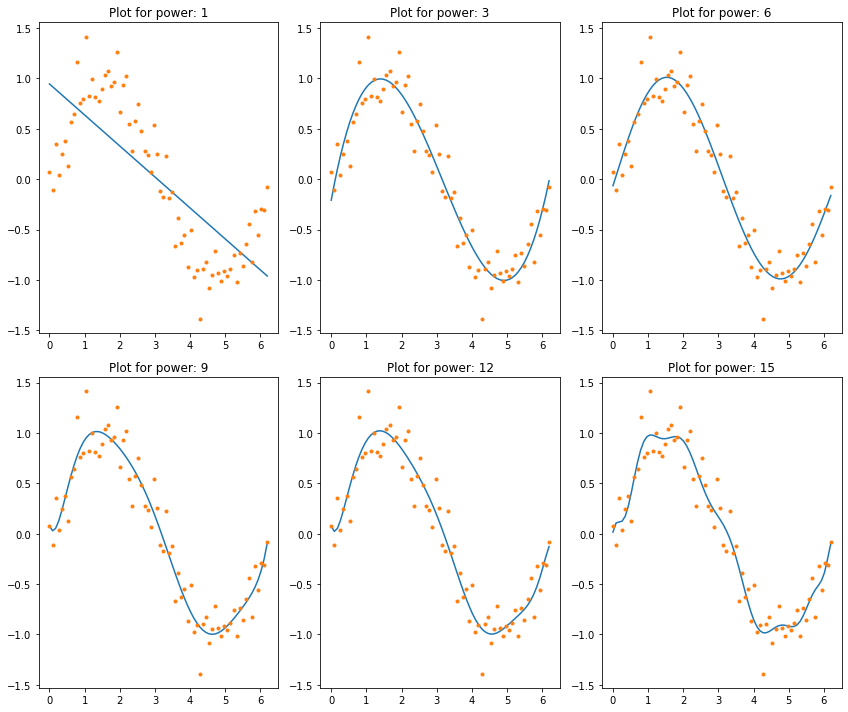

In [208]:
col = ['RSS', 'Intercept'] + ['coef_x_%d' % i for i in range(1, 16)]
ind = ['model_pow_%d' % i for i in range(1, 16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1:231, 3:232, 6:233, 9:234, 12:235, 15:236}

for i in range(1, 16):
    coef_matrix_simple.iloc[i-1, 0:i+2] = linear_regression(X, y, power=i, models_to_plot=models_to_plot)

In [209]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,RSS,Intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,16,-0.0089,-0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,16,-0.0089,-0.37,-0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,2.8,-0.0089,3.4,-10,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,2.8,-0.0089,3.5,-10,6.8,-0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,2.6,-0.0089,2.1,0.062,-20,29,-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,2.6,-0.0089,2,1.5,-26,39,-19,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,2.6,-0.0089,1.5,7.7,-59,1.3e+02,-1.4e+02,87,-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,2.4,-0.0089,-1.4,66,-4.8e+02,1.6e+03,-3.1e+03,3.4e+03,-2e+03,4.7e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,2.4,-0.0089,-2,80,-6.1e+02,2.3e+03,-4.8e+03,6.2e+03,-4.5e+03,1.8e+03,-2.8e+02,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,2.4,-0.0089,-1,49,-2.5e+02,1.1e+02,2.6e+03,-9.8e+03,1.7e+04,-1.6e+04,7.6e+03,-1.5e+03,NaN,NaN,NaN,NaN,NaN


**Podsumowanie**:

- wielkość współczynników regresji rośnie eksponencjalnie wraz ze wzrostem złożoności modelu,
- wielkość współczynnika regresji wpływa na istotność zmiennej odpowiadającej temu współczynnikowi w oszacowaniu wielkość zmiennej odpowiedzi, ale gdy wielkość współczynnik jest zbyt duża, algorytm modeluje skomplikowane relacje w celu oszacowania wyników, co często kończy się zbytnim dopasowaniem do danych,

# Regularyzacja grzbietowa (ang. *rigde regression*)

Metoda najmniejszych kwadratów z regularyzacją $l2$, minimalizuje **funkcję kryterialną**:

$$||y - Xb||^2_2 + \alpha \cdot ||b||^2_2,$$

gdzie dla dowolnego wektora $n$-wymiarowego $a = (a_1, a_2, \ldots, a_n)$ zachodzi: $||a||_2 = \sqrt{\sum_{i=1}^n a_i^2}$.

$\alpha$ - siła regularyzacja, $\alpha > 0$ 

* gdy $\alpha = 0$ -- problem uprasza się do zwykłej regresji
* gdy $\alpha = +\infty$ -- współczynnik są równe zeru
* gdy $0 < \alpha < +\infty$ -- 

TODO:: jaki algorytm jest wykorzystywany do wyznaczenia b

In [187]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha, power, models_to_plot={}):
    
    ridgereg= make_pipeline(PolynomialFeatures(power),
                             StandardScaler(),
                             Ridge(alpha=alpha))
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(X, y_pred)
        plt.plot(X, y,'.')
        plt.title('Plot for alpha: %.3g' % alpha)
    
    #Return the result in pre-defined format
    ret = [rss_fun(y, y_pred)]
    ret.extend([ridgereg.named_steps['ridge'].intercept_])
    ret.extend(ridgereg.named_steps['ridge'].coef_[1:])
    return ret

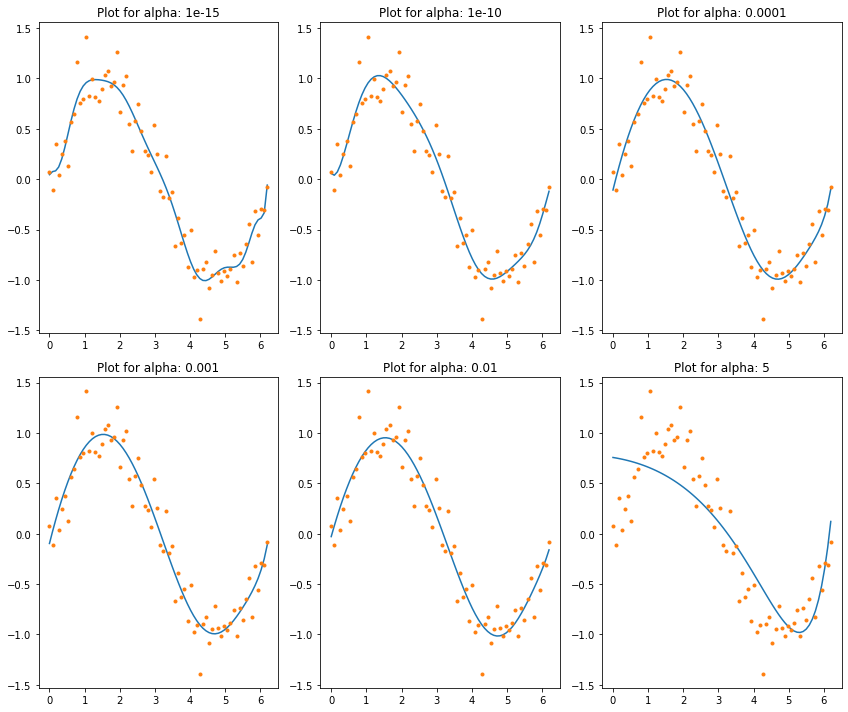

In [189]:
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

col = ['RSS','Intercept'] + ['coef_x_%d'%i for i in range(1, 16)]
ind = ['alpha_%.2g' % alpha_ridge[i] for i in range(0, len(alpha_ridge))]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(X, y, alpha_ridge[i], 15, models_to_plot)

In [190]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,RSS,Intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,2.3,-0.0089,1.6,-1e+02,2.9e+03,-3.1e+04,1.9e+05,-6.7e+05,1.5e+06,-2e+06,1.1e+06,5.4e+05,-1.2e+06,3.2e+05,4.9e+05,-4.2e+05,1e+05
alpha_1e-10,2.4,-0.0089,-1,53,-3.3e+02,8.6e+02,-9.4e+02,2e+02,-21,4.7e+02,3.6e+02,-7.7e+02,-8.1e+02,7.7e+02,1.2e+03,-1.4e+03,4e+02
alpha_1e-08,2.4,-0.0089,-0.35,39,-2.4e+02,5.5e+02,-4.3e+02,-2e+02,2.5e+02,2.6e+02,-7.9,-2.1e+02,-1.8e+02,19,1.7e+02,1e+02,-1.1e+02
alpha_0.0001,2.6,-0.0089,2.6,-5,-2.1,2.6,1.4,0.4,0.65,0.95,0.59,-0.32,-1.3,-1.7,-1.3,0.01,2.3
alpha_0.001,2.6,-0.0089,2.5,-4.9,-1.7,1.2,1.9,1.6,1,0.29,-0.37,-0.87,-1.1,-1,-0.54,0.27,1.4
alpha_0.01,2.6,-0.0089,2.3,-4.3,-1.7,0.72,1.6,1.5,0.98,0.29,-0.3,-0.69,-0.84,-0.74,-0.39,0.17,0.92
alpha_1,6.5,-0.0089,0.32,-0.86,-0.69,-0.3,0.009,0.2,0.29,0.31,0.28,0.22,0.14,0.049,-0.043,-0.14,-0.22
alpha_5,9.3,-0.0089,-0.1,-0.39,-0.32,-0.18,-0.062,0.021,0.073,0.099,0.11,0.1,0.091,0.072,0.05,0.026,0.0019
alpha_10,10,-0.0089,-0.17,-0.3,-0.24,-0.15,-0.069,-0.0097,0.03,0.055,0.069,0.074,0.074,0.07,0.063,0.055,0.045
alpha_20,11,-0.0089,-0.19,-0.24,-0.19,-0.12,-0.068,-0.025,0.0068,0.029,0.044,0.054,0.059,0.062,0.063,0.062,0.061


**Podsumowanie**:

- wielkość RSS (suma kwadratów błędów) rośnie wraz ze wzrostem wartości $\alpha$, wraz z redukcją złożoności modelu,
- $\alpha = 1e-15$ daje istotną redukcję wielkości współczynników regresji,
- wyższe wartości $\alpha$ prowadzą do niedouczenia modelu (gwałtowny wzrost RSS dla $\alpha > 1$.
- wiele współczynników jest bardzo małych, ale nie równych zeru.

# Regularyzacja Lasso (ang. *Lasso regression*)

LASSO - Least Absolute Shrinkage and Selection Operator

Metoda najmniejszych kwadratów z regularyzacją $l1$, minimalizuje **funkcję kryterialną**:

$$||y - Xb||^2_2 + \alpha \cdot ||b||^2_1,$$

gdzie dla dowolnego wektora $n$-wymiarowego $a = (a_1, a_2, \ldots, a_n)$ zachodzi: $||a||_1 = \sqrt{\sum_{i=1}^n |a_i|}$.

In [200]:
from sklearn.linear_model import Lasso

def lasso_regression(X, y, alpha, power, models_to_plot={}):
    
    lassoreg = make_pipeline(PolynomialFeatures(power),
                             StandardScaler(),
                             Lasso(alpha=alpha, max_iter=1e5))
    
    lassoreg.fit(X, y)
    y_pred = lassoreg.predict(X)
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(X, y_pred)
        plt.plot(X, y, '.')
        plt.title('Plot for alpha: %.3g' % alpha)
    
    #Return the result in pre-defined format
    ret = [rss_fun(y, y_pred)]
    ret.extend([lassoreg.named_steps['lasso'].intercept_])
    ret.extend(lassoreg.named_steps['lasso'].coef_[1:])
    return ret

/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2847563047547457, tolerance: 0.003872546082938729
  positive)
/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2846950535261472, tolerance: 0.003872546082938729
  positive)
/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2786265112515518, tolerance: 0.003872546082938729
  positive)
/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

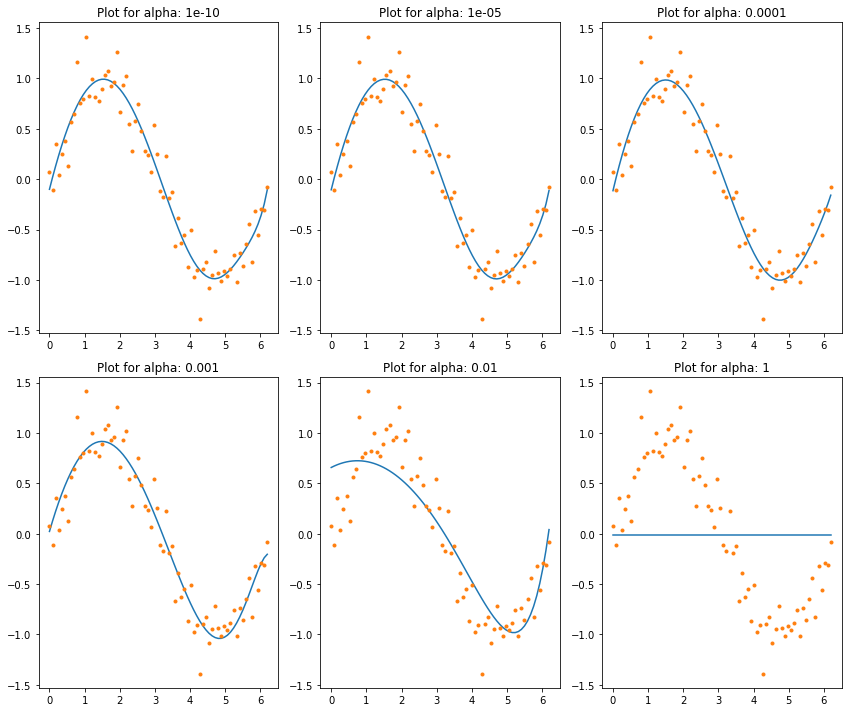

In [202]:
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

col = ['RSS','Intercept'] + ['coef_x_%d' % i for i in range(1, 16)]
ind = ['alpha_%.2g' % alpha_lasso[i] for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(X, y, alpha_lasso[i], 15, models_to_plot)

In [203]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,RSS,Intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,2.6,-0.0089,2.5,-4.6,-2.7,1.8,2.2,1.8,0.89,-0.029,-0.72,-1,-1,-0.69,-0.19,0.4,1
alpha_1e-10,2.6,-0.0089,2.5,-4.6,-2.7,1.8,2.2,1.8,0.89,-0.029,-0.72,-1,-1,-0.69,-0.19,0.4,1
alpha_1e-08,2.6,-0.0089,2.5,-4.6,-2.7,1.8,2.2,1.8,0.89,-0.027,-0.72,-1,-1,-0.69,-0.19,0.4,1
alpha_1e-05,2.6,-0.0089,2.6,-4.9,-2,1.1,2.7,1.6,0.35,0,0,-1.3,-1.1,-0.53,-0,-0,1.1
alpha_0.0001,2.6,-0.0089,2.7,-5.9,-0,0,3.8,0,0,-0,-0,-0.39,-1,-0,-0,0,0.46
alpha_0.001,2.8,-0.0089,2.2,-4.8,-0,0,2.4,0.12,0,0,0,-0,-0,-0,-0,-0.21,-0.1
alpha_0.01,7.3,-0.0089,0.33,-1.4,-0,-0,0,0,0,0.49,0.16,0,0,0,0,0,0
alpha_1,39,-0.0089,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,39,-0.0089,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,39,-0.0089,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


**Podsumowanie**:

- wielkość RSS (suma kwadratów błędów) rośnie wraz ze wzrostem wartości 𝛼, wraz z redukcją złożoności modelu,
- dla tych samym wartości $\alpha$, wielkość współczynników regresji z regularyzacją Lasso jest mniejsza niż wartości odpowiadających współczynników w regresji z regularyzacją grzbietową,
- dla tych samych wartości $\alpha$ regresji z regularyzacją Lasso ma wyższe RSS w porównaniu do regresji z regularyzacją grzbietową (gorsze dopasowanie modelu),
- wiele współczynników jest zerowa (nawet dla niewielkich wielkości $\alpha$).

## Porównanie regularyzacji grzbietowej z regularyzacją Lasso

### Ridge
- zawiera wszystkie (lub żadne) cechy w modelu, główną zaletą tej regularyzacji jest **ściągniecie współczynników** (ang. **shrinkage coefficient**),
- regresji grzbietowej używa się głowniej do **uniknięcia przeuczenia** modelu, ale z racji, że zawiera wszystkie zmienne z modelu nie jest użyteczny w przypadku wielowymiarowych danych (gdy liczbę predyktorów szacuje się milionach/miliardach -- zbyt duża złożoność obliczeniowa),
- zasadniczo działa dobrze nawet w obecności silnie **skorelowanych** cech -- uwzględnia wszystkie skorelowane zmienne w modelu, ale wielkość współczynników zależy od wielkości korelacji.


### Lasso 
- regularyzacja Lasso poza **ściągniecie współczynników**, dokonuje również selekcji zmiennych
- regularyzacje Lasso często wykorzystuje się do **selekcji zmiennych** w przypadku do liczba cech jest rzędu milionów/miliardów
- wybiera dowolną cechę spośród cech silnie skorelowanych, współczynniki pozostałych cechy skorelowanych z wybraną zmienną redukuje do zera, ale wybrana zmienna zmienia się losowo wraz ze zmianą parametrów modelu -- podejście te działa gorzej niż regularyzacja grzbietowa